# Parámetros de un kernel Gaussiano

In [75]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tensorflow.python.framework import ops

In [89]:
session = tf.Session()

iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])  

In [90]:
# Setosa
class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == 1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == 1]

# No setosa
class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == -1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == -1]

In [91]:
gammas = [1.0, 10.0, 25.0, 100.0]

In [96]:
batch_size = 150

x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[1, batch_size]))

gamma = tf.constant(-5.0)

# COPIAMOS DEL NOTEBOOK ANTERIOR

dist = tf.reduce_sum(tf.square(x_data), axis=1) # Sumatorio por columnas
dist = tf.reshape(dist, [-1,1]) # Para poder hacer las opeeraciones matriciales
sq_distance = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))

# Kernel Gaussiano
kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_distance))) 

first_sum = tf.reduce_sum(b) # Sumatorio de b_i

b_vect_cross = tf.matmul(tf.transpose(b), b) # b_i * b_j
y_target_cross = tf.matmul(y_target, tf.transpose(y_target)) # y_i * y_j
second_sum = tf.reduce_sum(tf.multiply(kernel, tf.multiply(b_vect_cross, y_target_cross)))

loss = tf.negative(tf.subtract(first_sum, second_sum))

rA = tf.reshape(tf.reduce_sum(tf.square(x_data), axis=1), [-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), axis=1), [-1,1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                      tf.transpose(rB))

pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.002)
train = optimizer.minimize(loss) # Es lo mismo que maximizar la función del principio del todo

init = tf.global_variables_initializer()
session.run(init)

loss_vector = []
accuracy_vector = []

for i in range(1000):
    rand_idx = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = np.transpose([y_vals[rand_idx]])
    session.run(train, feed_dict={x_data: rand_x, 
                                  y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, 
                                             y_target: rand_y})
    
    loss_vector.append(temp_loss)
    
    temp_acc = session.run(accuracy, feed_dict={x_data: rand_x, 
                                                y_target: rand_y, 
                                                prediction_grid: rand_x})
    
    accuracy_vector.append(temp_acc)
    
    if (i+1)%100 == 0:
        print("Step #{} ==> Loss: {}, Accuracy: {}".format(i+1, temp_loss, temp_acc))
        
x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals, 
                                                        y_target: np.transpose([y_vals]), 
                                                        prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Step #100 ==> Loss: 52.51556396484375, Accuracy: 0.6133333444595337
Step #200 ==> Loss: 22.728099822998047, Accuracy: 0.47999998927116394
Step #300 ==> Loss: 16.82335662841797, Accuracy: 0.6733333468437195
Step #400 ==> Loss: 2.9376769065856934, Accuracy: 0.7866666913032532
Step #500 ==> Loss: 2.0415501594543457, Accuracy: 0.846666693687439
Step #600 ==> Loss: 0.1085512638092041, Accuracy: 0.7133333086967468
Step #700 ==> Loss: -1.566549301147461, Accuracy: 0.9066666960716248
Step #800 ==> Loss: -1.7720293998718262, Accuracy: 1.0
Step #900 ==> Loss: -1.2807278633117676, Accuracy: 0.9200000166893005
Step #1000 ==> Loss: -1.9128540754318237, Accuracy: 0.9133333563804626


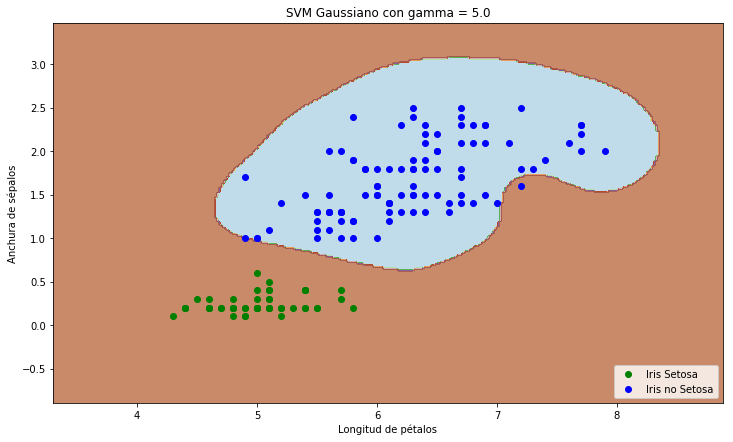

In [97]:
plt.figure(figsize=(12,7))
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.7)
plt.plot(class1_x, class1_y, "go", label="Iris Setosa")
plt.plot(class2_x, class2_y, "bo", label="Iris no Setosa")
plt.title("SVM Gaussiano con gamma = {}".format(-session.run(gamma)))
plt.xlabel("Longitud de pétalos")
plt.ylabel("Anchura de sépalos")
plt.legend(loc="lower right")
plt.show()

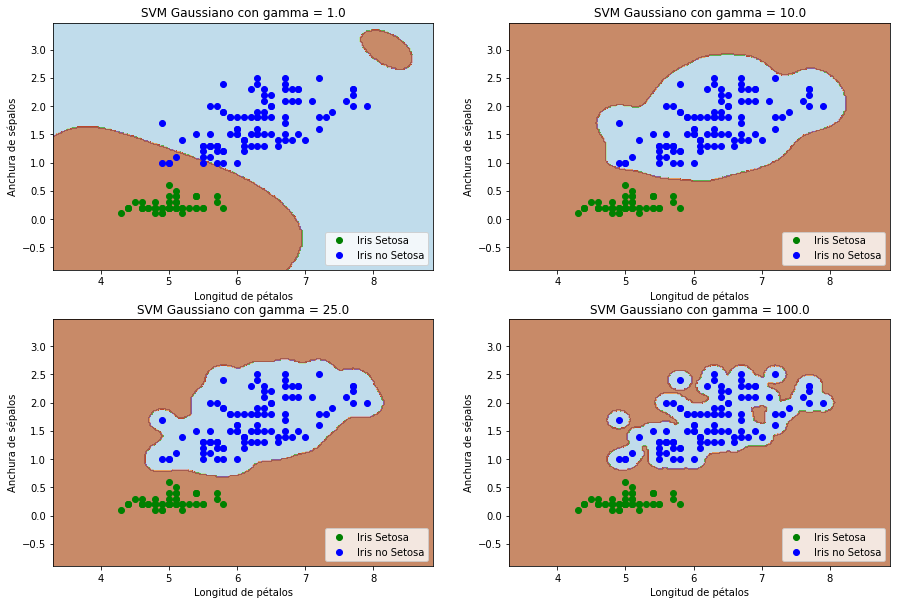

In [116]:
#fig, ax = plt.subplots(nrows=2, ncols=2)
j = 0

plt.figure(figsize=(15,10))

for g in gammas:
    batch_size = 150

    x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

    b = tf.Variable(tf.random_normal(shape=[1, batch_size]))

    gamma = tf.constant(-g)

    # COPIAMOS DEL NOTEBOOK ANTERIOR

    dist = tf.reduce_sum(tf.square(x_data), axis=1) # Sumatorio por columnas
    dist = tf.reshape(dist, [-1,1]) # Para poder hacer las opeeraciones matriciales
    sq_distance = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))

    # Kernel Gaussiano
    kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_distance))) 

    first_sum = tf.reduce_sum(b) # Sumatorio de b_i

    b_vect_cross = tf.matmul(tf.transpose(b), b) # b_i * b_j
    y_target_cross = tf.matmul(y_target, tf.transpose(y_target)) # y_i * y_j
    second_sum = tf.reduce_sum(tf.multiply(kernel, tf.multiply(b_vect_cross, y_target_cross)))

    loss = tf.negative(tf.subtract(first_sum, second_sum))

    rA = tf.reshape(tf.reduce_sum(tf.square(x_data), axis=1), [-1,1])
    rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), axis=1), [-1,1])

    pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                          tf.transpose(rB))

    pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

    prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
    prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.002)
    train = optimizer.minimize(loss) # Es lo mismo que maximizar la función del principio del todo

    init = tf.global_variables_initializer()
    session.run(init)

    loss_vector = []
    accuracy_vector = []

    for i in range(1000):
        rand_idx = np.random.choice(len(x_vals), size=batch_size)
        rand_x = x_vals[rand_idx]
        rand_y = np.transpose([y_vals[rand_idx]])
        session.run(train, feed_dict={x_data: rand_x, 
                                      y_target: rand_y})

        temp_loss = session.run(loss, feed_dict={x_data: rand_x, 
                                                 y_target: rand_y})

        loss_vector.append(temp_loss)

        temp_acc = session.run(accuracy, feed_dict={x_data: rand_x, 
                                                    y_target: rand_y, 
                                                    prediction_grid: rand_x})

        accuracy_vector.append(temp_acc)

    x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
    y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    [grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals, 
                                                            y_target: np.transpose([y_vals]), 
                                                            prediction_grid: grid_points})
    grid_predictions = grid_predictions.reshape(xx.shape)
    
    plt.subplot(2, 2, j+1)
    plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.7)
    plt.plot(class1_x, class1_y, "go", label="Iris Setosa")
    plt.plot(class2_x, class2_y, "bo", label="Iris no Setosa")
    plt.title("SVM Gaussiano con gamma = {}".format(-session.run(gamma)))
    plt.xlabel("Longitud de pétalos")
    plt.ylabel("Anchura de sépalos") 
    plt.legend(loc="lower right")
    
    j += 1
    
plt.show()